<Center>
<h4>FUNDAÇÃO DE ASSISTÊNCIA E EDUCAÇÃO</h4>
<h4>CENTRO UNIVERSITÁRIO ESPÍRITO-SANTENSE</h4>
<h2>ANÁLISE DE SENTIMENTOS APLICADA À EXTRAÇÃO DE FEEDBACKS EM COMENTÁRIOS NAS REDES SOCIAIS</h2>

<h4>LORENZO SALVIATO VESCOVI</h4>
<h4>VINICIUS ROSSMANN NUNES</h4>

<h4>Orientado por: Otávio Lube dos Santos</h4>
    
<h4>VITÓRIA- 2023</h4>

</Center>

### Introdução

Esse protótipo busca treinar, avaliar e testar modelos de classificação de textos em sentimentos (positivo e negativo).<br>
Para realizar o treino e validação, foi utilizado um conjunto de dados abertos de avaliações de produtos, o <b>B2W-Reviews01</b>, que contém mais de 130 mil avaliações de clientes de comércio eletrônico, coletadas do site Americanas.com entre janeiro e maio de 2018.

### Preparando o conjunto de dados

Importando a base de dados

In [1]:
import pandas as pd
b2wReviews1 = pd.read_csv('./datasets/B2W-Reviews01.csv', dtype={"product_id": str, "review_text": str})
b2wReviews1.columns

Index(['submission_date', 'reviewer_id', 'product_id', 'product_name',
       'product_brand', 'site_category_lv1', 'site_category_lv2',
       'review_title', 'overall_rating', 'recommend_to_a_friend',
       'review_text', 'reviewer_birth_year', 'reviewer_gender',
       'reviewer_state'],
      dtype='object')

Para os objetivos desse trabalho, alguns campos como "Data de submissão", "Codigo do produto" e "Gênero do avaliador" não serão utilizados, e portanto vamos remove-los:

In [2]:
b2wReviews1.drop(
    columns = [
        "submission_date",
        "reviewer_id", 
        "product_id",
        "product_brand",
        "site_category_lv1",
        "reviewer_birth_year",
        "reviewer_gender",
        "reviewer_state"
    ],
    inplace = True
)
b2wReviews1.head()

,product_name,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text
0,Notebook Asus Vivobook Max X541NA-GO472T Intel...,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...
1,Copo Acrílico Com Canudo 500ml Rocie,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ..."
2,Panela de Pressão Elétrica Philips Walita Dail...,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3,Betoneira Columbus - Roma Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de..."


As colunas "overall_rating" e "review_text" são críticas, vamos examinar as linhas que tem esses campos nulos:

In [3]:
b2wReviews1[b2wReviews1.review_text.isna() | b2wReviews1.review_text.isna()].shape[0]

3275

Existem 3275 linhas com esses campos nulos, vamos excluir esses registros:

In [4]:
b2wReviews1 = b2wReviews1.dropna(subset=["review_text", "overall_rating"])
b2wReviews1[b2wReviews1.review_text.isna() | b2wReviews1.review_text.isna()].shape[0]

0

Em nossa classificação, vamos ignorar as notas "neutras" com valor 3, vamos considerar notas maiores que 3 como "positivas" e as demais como "negativas":

In [5]:
b2wReviews1 = b2wReviews1[b2wReviews1['overall_rating'] != 3]
b2wReviews1['polarity'] = b2wReviews1['overall_rating'].apply(lambda x: 'positive' if x > 3 else 'negative')
b2wReviews1.head()

,product_name,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,polarity
0,Notebook Asus Vivobook Max X541NA-GO472T Intel...,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,positive
1,Copo Acrílico Com Canudo 500ml Rocie,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",positive
2,Panela de Pressão Elétrica Philips Walita Dail...,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,positive
3,Betoneira Columbus - Roma Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,positive
4,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",positive


Agora vamos avaliar a quantidade de avaliações em cada polaridade:

In [6]:
b2wReviews1.polarity.value_counts()

positive    79316
negative    33772
Name: polarity, dtype: int64

Podemos observar que existe uma quantidade maior de avaliações positivas.<br>
Nesse caso é importante equalizar a quantidade de dados de treinamento em cada polaridade (positiva e negativa), para evitar viés nos modelos de classificação, garantindo que o modelo não se torne tendencioso para a classe majoritária.<br><br>
Para isso, vamos utilizar a técnica conhecida como <b>undersampling</b>,que consiste em manter todos os dados da classe com menor frequência e diminuir a quantidade dos que estão na classe de maior frequência:

In [7]:
positive = b2wReviews1.query("polarity == 'positive'").sample(33772)
negative = b2wReviews1.query("polarity == 'negative'")
b2wReviews1 = pd.concat([positive, negative])
b2wReviews1.polarity.value_counts()

positive    33772
negative    33772
Name: polarity, dtype: int64

### Pré processamento das avaliações

O pré-processamento de texto é uma etapa crítica na classificação de texto e em tarefas de processamento de linguagem natural (NLP) em geral. Existem várias razões pelas quais o pré-processamento de texto é importante:

* Normalização de Dados: O pré-processamento ajuda a normalizar os dados textuais, o que significa que ele coloca os textos em um formato consistente e padronizado. Isso é importante porque diferentes textos podem conter formatação, capitalização e estruturas diferentes, o que pode dificultar a comparação e análise.

* Redução de Ruído: Textos muitas vezes contêm informações irrelevantes, como espaços em branco extras, pontuação, caracteres especiais e tags HTML. O pré-processamento ajuda a eliminar esses elementos indesejados, o que melhora a qualidade dos dados e evita que o modelo se distraia com informações desnecessárias.

* Remoção de Stopwords: Stopwords são palavras comuns, como "e", "em", "o", "a", "de", "que", que não contribuem significativamente para o significado do texto. A remoção de stopwords reduz a dimensionalidade dos dados e ajuda o modelo a se concentrar em palavras mais informativas.

* Stemming ou Lematização: Stemming e lematização são técnicas para reduzir as palavras à sua forma raiz. Isso ajuda a agrupar palavras semelhantes e a lidar com variações morfológicas. Por exemplo, "correr" e "correndo" podem ser reduzidos a "corr" pela técnica de stemming.

* Eliminação de Variações de Palavras: O pré-processamento também ajuda a lidar com variações de palavras, como singular/plural, tempos verbais e conjugações. Isso garante que o modelo possa reconhecer palavras relacionadas como equivalentes.

* Melhoria da Eficiência Computacional: Ao reduzir a quantidade de dados e melhorar a qualidade, o pré-processamento torna a análise de texto mais eficiente em termos de recursos computacionais.

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def preprocess_text(text):
    # Remoção de caracteres especiais e números
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remoção de stopwords
    words = text.lower().split()
    words = [word for word in words if word not in stopwords.words('portuguese')]
    # Stemming
    stemmer = SnowballStemmer('portuguese')
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

b2wReviews1['processed_text'] = b2wReviews1['review_text'].apply(preprocess_text)

### Vetorização

A vetorização de textos é um processo fundamental na análise de sentimentos, que envolve a transformação de texto em dados numéricos que podem ser processados por algoritmos de aprendizado de máquina. Isso permite que os modelos de análise de sentimentos compreendam e classifiquem o conteúdo de texto com base em emoções, opiniões e polaridade, como positivo, negativo ou neutro.<br><br>
Para esse trabalho, vamos utilizar a técnica TF-IDF, que atribui um valor a cada palavra com base em sua frequência no documento e na frequência inversa em todo o corpus de documentos. Isso ajuda a destacar palavras importantes e reduzir o peso de palavras comuns.<br><br>
Primeiro, vamos separar o conjunto de dados em um conjunto de treino e um conjunto de validaçãom seguindo a proporção 80/20, com 80% sendo utilizado para treino e 20% para validação:

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(b2wReviews1['processed_text'], b2wReviews1['polarity'], test_size=0.2, random_state=42)

Em seguida, vamos utilizar o TF-IDF para vetorizar o textos pré processados de treino e validação:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)

### Treinando e avaliando modelos

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier,  RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix , classification_report

models = []
#models.append(('MultinomialNB', MultinomialNB()))
models.append(('LogisticRegression', LogisticRegression(random_state=1, tol=1e-5,max_iter = 100000)))
#models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
#models.append(('KNeighborsClassifier', KNeighborsClassifier()))
#models.append(('BaggingClassifier', BaggingClassifier()))
#models.append(('RandomForestClassifier',RandomForestClassifier()))
#models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=100)))
#models.append(('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=100)))
#models.append(('AdaBoostClassifier', AdaBoostClassifier(n_estimators=100)))

metricas = ['accuracy', 'f1_micro', 'f1_macro', 'precision' , 'recall', 'roc_auc']
kfold = KFold(n_splits=10, shuffle=True)

resultados = []
modelos = []

for name, model in models:
    modelos.append(name)
    
    outcome = y_train
    predictor = X_train_vect
    
    model.fit(X_train_vect, y_train)
    
    y_pred = model.predict(X_val_vect)

    # Calcule métricas de avaliação
    accuracy = accuracy_score(y_val, y_pred)
    #precision = precision_score(y_val, y_pred, average='weighted')
    #recall = recall_score(y_val, y_pred, average='weighted')

    print(f'Acurácia {name}: {accuracy}')
    #print(f'Precisão: {precision}')
    #print(f'Recall: {recall}')
    
    # Validação cruzada
    #cv_result = cross_validate(model, predictor, outcome, cv=kfold, scoring=metricas, verbose=False)
    #print(cv_result)
    #result = []
    #for metrica in metricas:
    #    key = "test_"+metrica;
    #    result.append(cv_result[key].mean())
    #resultados.append(result)
    
#tabela_resultado = pd.DataFrame(data=resultados, columns=metricas, index=modelos)
#tabela_resultado

Acurácia LogisticRegression: 0.9301206603005404


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

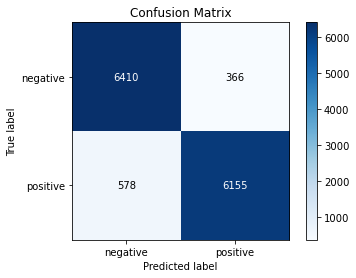

In [28]:
import scikitplot as skplt
from sklearn.metrics import confusion_matrix , classification_report
modelo = models[0][1]
predict = modelo.predict(X_val_vect)
skplt.metrics.plot_confusion_matrix(y_val, predict)

In [29]:
import pickle
pickle.dump(vectorizer, open('./models/vectorizer', 'wb'))
pickle.dump(modelo, open('./models/LogisticRegression', 'wb'))